In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()

,amount,created_at,reimbursement_date,GBP_EUR,inflation,BTC_GBP,unemploy_rate,transfer_type_regular,charge_moment_before
0,1.0,1.574172e+09,1.575587e+09,1.16935,1.3,6347.577148,3.9,True,False
1,100.0,1.575903e+09,1.576537e+09,1.18803,1.3,5630.115723,4.0,True,False


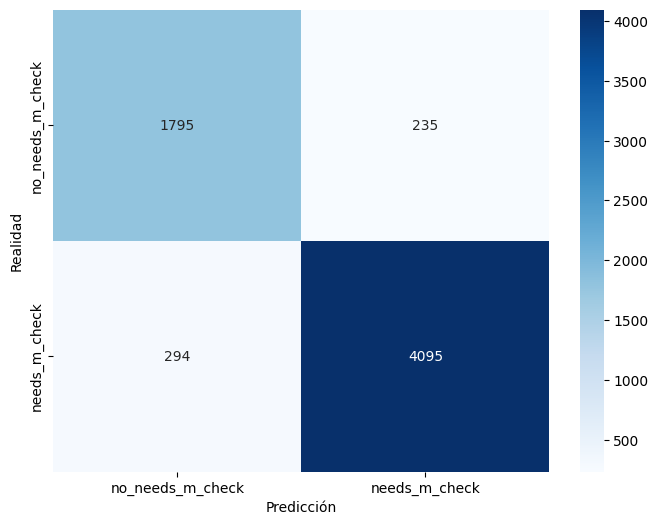

In [4]:
df = df_jo.copy()
# Convertir columnas datetime a timestamps
for col in df.select_dtypes(include=['datetime64']).columns:
    df[col] = df[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

df['moderada'] = df['moderated_at'].apply(lambda x: 1 if not pd.isnull(x) else 0)

# Variables predictoras (ajusta según los datos disponibles)
columnas = ['amount','created_at','transfer_type','charge_moment','reimbursement_date','GBP_EUR','inflation','BTC_GBP','unemploy_rate'] #,'fee', 'transfer_type', 'stat_cr','stat_fe', 'recovery_status','category']
X = df[columnas].copy()
# Categoricas
X = pd.get_dummies(X, columns=['transfer_type','charge_moment'], drop_first=True)

y = df['moderada'].copy()  #moderada # La columna de la variable objetivo
display(X.head(2))

# feature_names = X.columns # Obtener los nombres de las características
# # Divide los datos en conjuntos de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# # Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
# clf = LogisticRegression(solver="liblinear")
# clf.fit(X_train, y_train) # Entrena el clasificador
# predicciones = clf.predict(X_test) # Realiza predicciones sobre el conjunto de prueba

# Dividir el dataset en entrenamiento y prueba
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de Árbol de Decisión
DT = tree.DecisionTreeClassifier()

# Entrenar el modelo con el conjunto de datos de entrenamiento
DT.fit(train_X, train_y)

# Realizar predicciones sobre el conjunto de prueba
predictions = DT.predict(test_X)



# Genera las probabilidades de predicción
# predicciones_probabilidades = clf.predict_proba(X_test)

# # Crea un histograma de las probabilidades de predicción para ambas clases
# plt.figure(figsize=(10, 6)) 
# plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# # Histograma para la clase positiva (no need manual check)
# plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# # Título y etiquetas de los ejes
# plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
# plt.xlabel("Probabilidad de Predicción")
# plt.ylabel("Frecuencia")
# plt.legend(loc="upper center") 
# # Muestra la leyenda en el gráfico
# plt.grid(axis="y", linestyle="--", alpha=0.1)
# plt.show()

# # Muestra las primeras 10 probabilidades de predicción
# print(f"predicciones_probabilidades:\n {predicciones_probabilidades[:10]}\n")

# # Obtén los coeficientes y asigna los nombres de las características
# coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
# feature_coef = list(zip(feature_names, coeficientes))

# # Ordena las características por el valor absoluto del coeficiente en orden descendente
# feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# # Imprime cada variable junto con su coeficiente ordenado
# print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
# for feature, coef in feature_coef_sorted:
#     print(f"{feature}: {coef:.4f}")

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(test_y, predictions)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()
# Evaluate model performance
#print("Accuracy:", clf.score(test_X, test_y))  # Accuracy score
#print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report    